In [1]:
import sys
sys.path.append('..')

from scripts.data_loaders.common import show_sample
from scripts.data_loaders.PSST import PSSTDataset
from scripts.eval.evaluate import evaluate, simplify_ipa
from scripts.ipa_transcription.wav2vec2 import transcribe_batch, DEVICE

import torch
from transformers import AutoProcessor, AutoModelForCTC

import gc
import difflib
from collections import defaultdict

from IPython.display import clear_output
clear_output()

# Load Data
This will prompt for credentials if not already saved in ~/config/psstdata/settings.json

In [2]:
# train = PSSTDataset(split="train", include_speaker_info=True, force_offline=True)
# valid = PSSTDataset(split="valid", include_speaker_info=True, force_offline=True)
test = PSSTDataset(split='test', include_speaker_info=True, force_offline=True)
clear_output()

IPA: eɪhaʊs
Metadata: {'utterance_id': 'ACWT01a-BNT01-house', 'test': 'BNT', 'session': 'ACWT01a', 'text_prompt': 'house', 'correct': True, 'aq_index': 63.9}


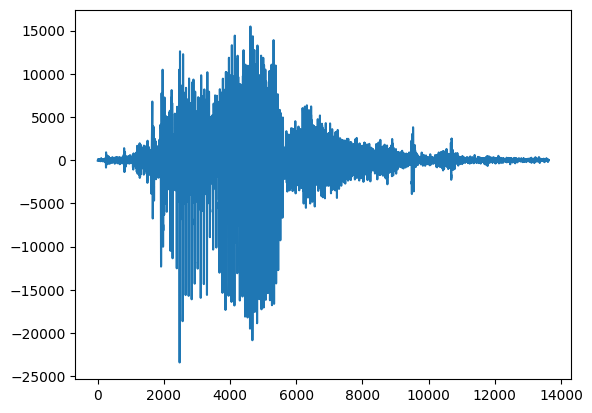

In [3]:
show_sample(test[0])


## Analyze substitution patterns

In [4]:
BATCH_SIZE = 4
average_cer = 0
average_feature_distance = 0
data = test  # Use the test split
amount = len(data)  # Get length from dataset

# List of all model IDs to evaluate
MODEL_IDS = [
    "KoelLabs/xlsr-timit-a1",
    "vitouphy/wav2vec2-xls-r-300m-timit-phoneme",
    "speech31/wav2vec2-large-TIMIT-IPA",
    "speech31/wav2vec2-large-english-TIMIT-phoneme_v3",
    "speech31/wav2vec2-large-TIMIT-IPA2"
]

In [5]:
def analyze_substitution_patterns(ground_truth: str, prediction: str) -> 'dict[str, list[str]]':
    """Analyze character substitution patterns between ground truth and prediction."""
    matcher = difflib.SequenceMatcher(None, ground_truth, prediction)
    substitutions = defaultdict(list)
    
    for op, i1, i2, j1, j2 in matcher.get_opcodes():
        if op == 'replace':
            gt_chars = ground_truth[i1:i2]
            pred_chars = prediction[j1:j2]
            substitutions[gt_chars].append(pred_chars)
    
    return dict(substitutions)

In [6]:
def analyze_model_patterns(high_cer_cases: 'list[dict]') -> dict:
    """Analyze patterns in high CER cases."""
    patterns = {
        'substitutions': defaultdict(int),
        'length_diffs': [],
        'common_additions': defaultdict(int),
        'common_deletions': defaultdict(int)
    }
    
    for case in high_cer_cases:
        gt = case['ground_truth']
        pred = case['prediction']
        
        # Analyze length differences
        patterns['length_diffs'].append(len(pred) - len(gt))
        
        # Find substitutions
        subs = analyze_substitution_patterns(gt, pred)
        for orig, replacements in subs.items():
            for repl in replacements:
                patterns['substitutions'][f"{orig} → {repl}"] += 1
        
        # Find additions and deletions using difflib
        matcher = difflib.SequenceMatcher(None, gt, pred)
        for op, i1, i2, j1, j2 in matcher.get_opcodes():
            if op == 'insert':
                added = pred[j1:j2]
                patterns['common_additions'][added] += 1
            elif op == 'delete':
                deleted = gt[i1:i2]
                patterns['common_deletions'][deleted] += 1
    
    # Convert defaultdicts to regular dicts
    patterns['substitutions'] = dict(sorted(patterns['substitutions'].items(), 
                                          key=lambda x: x[1], reverse=True))
    patterns['common_additions'] = dict(sorted(patterns['common_additions'].items(), 
                                             key=lambda x: x[1], reverse=True))
    patterns['common_deletions'] = dict(sorted(patterns['common_deletions'].items(), 
                                             key=lambda x: x[1], reverse=True))
    
    return patterns

In [7]:
def evaluate_model(model_id, results):
    print(f"\nEvaluating model: {model_id}")
    
    high_cer_cases = []
    suspicious_cases = []  # Cases with high CER but low feature distance
    
    try:
        processor = AutoProcessor.from_pretrained(model_id)
        model = AutoModelForCTC.from_pretrained(model_id).to(DEVICE)
        
        average_cer = 0
        average_feature_distance = 0
        
        for i in range(0, amount, BATCH_SIZE):
            if DEVICE == 'cuda':
                torch.cuda.empty_cache()
            elif DEVICE == 'mps':
                torch.mps.empty_cache()
                
            size = min(BATCH_SIZE, amount - i)
            batch = [data[idx] for idx in range(i, i+size)]
            transcriptions = transcribe_batch(batch, model, processor)
            
            for j in range(size):
                true_ipa = simplify_ipa(batch[j][0])
                transcription = simplify_ipa(transcriptions[j])
                cer_score, feature_distance = evaluate(true_ipa, transcription)
                average_cer += cer_score
                average_feature_distance += feature_distance
                
                case_data = {
                    'ground_truth': true_ipa,
                    'prediction': transcription,
                    'cer': cer_score,
                    'fer': feature_distance
                }
                
                # Store cases where CER > 1
                if cer_score > 1:
                    high_cer_cases.append(case_data)
                    
                    # Identify suspicious cases (high CER, low feature distance)
                    if feature_distance < 28:  # Threshold based on your data
                        suspicious_cases.append(case_data)
            
            print(f"Progress: {min(i + BATCH_SIZE, amount)}/{amount}", end='\r')
        
        final_cer = average_cer / amount
        final_feature_distance = average_feature_distance / amount
        
        # Analyze patterns in suspicious cases
        suspicious_patterns = None
        if suspicious_cases:
            suspicious_patterns = analyze_model_patterns(suspicious_cases)
        
        results[model_id] = {
            'cer': final_cer,
            'feature_distance': final_feature_distance,
            'high_cer_cases': high_cer_cases,
            'suspicious_cases': suspicious_cases,
            'suspicious_patterns': suspicious_patterns
        }
        
        print(f"\nResults for {model_id}:")
        print(f"Average CER: {final_cer:.4f}")
        print(f"Average Feature Distance: {final_feature_distance:.4f}")
        
        if suspicious_cases:
            print(f"\nFound {len(suspicious_cases)} suspicious cases (CER > 1, Feature Distance < 28):")
            print("\nPattern Analysis:")
            
            if suspicious_patterns:
                # Print top substitution patterns
                print("\nTop 5 Character Substitution Patterns:")
                for pattern, count in list(suspicious_patterns['substitutions'].items())[:5]:
                    print(f"  {pattern}: {count} times")
                
                # Print length statistics
                length_diffs = suspicious_patterns['length_diffs']
                avg_length_diff = sum(length_diffs) / len(length_diffs)
                print(f"\nAverage length difference: {avg_length_diff:.2f} characters")
                
                # Print common additions/deletions
                print("\nTop 3 Common Additions:")
                for added, count in list(suspicious_patterns['common_additions'].items())[:3]:
                    print(f"  Added '{added}': {count} times")
                
                print("\nTop 3 Common Deletions:")
                for deleted, count in list(suspicious_patterns['common_deletions'].items())[:3]:
                    print(f"  Deleted '{deleted}': {count} times")
            
            # Print example cases
            print("\nExample Suspicious Cases:")
            for idx, case in enumerate(suspicious_cases[:3], 1):  # Show first 3 cases
                print(f"\nCase {idx}:")
                print(f"Ground Truth: {case['ground_truth']}")
                print(f"Prediction:   {case['prediction']}")
                print(f"CER: {case['cer']:.4f}")
                print(f"FER: {case['fer']:.4f}")
                
                # Print character-by-character comparison
                print("\nCharacter comparison:")
                max_len = max(len(case['ground_truth']), len(case['prediction']))
                print("Ground Truth: " + " ".join(c.ljust(1) for c in case['ground_truth'].ljust(max_len)))
                print("Prediction:   " + " ".join(c.ljust(1) for c in case['prediction'].ljust(max_len)))
    finally:
        if 'model' in locals():
            del model
        if 'processor' in locals():
            del processor
        gc.collect()
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        elif DEVICE == 'mps':
            torch.mps.empty_cache()

In [8]:
results = {}
for model_id in MODEL_IDS:
    evaluate_model(model_id, results)


Evaluating model: KoelLabs/xlsr-timit-a1


Progress: 652/652
Results for KoelLabs/xlsr-timit-a1:
Average CER: 0.7034
Average Feature Distance: 0.1820

Found 82 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  ɪ → i: 5 times
  ʌ → i: 3 times
  ɪŋ → in: 2 times
  ʌʃ → oʊɡɪn: 1 times
  wɑʃɪŋ → əfɔɹʒʔɛn: 1 times

Average length difference: 6.04 characters

Top 3 Common Additions:
  Added 't': 4 times
  Added 'd': 3 times
  Added 'm': 3 times

Top 3 Common Deletions:
  Deleted 'b': 3 times
  Deleted 'u': 2 times
  Deleted 'k': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: bɹʌʃ
Prediction:   ɹoʊɡɪn
CER: 1.5000
FER: 0.3815

Character comparison:
Ground Truth: b ɹ ʌ ʃ    
Prediction:   ɹ o ʊ ɡ ɪ n

Case 2:
Ground Truth: wɑʃɪŋ
Prediction:   əfɔɹʒʔɛn
CER: 1.6000
FER: 0.3569

Character comparison:
Ground Truth: w ɑ ʃ ɪ ŋ      
Prediction:   ə f ɔ ɹ ʒ ʔ ɛ n

Case 3:
Ground Truth: kætɑmkætɑm
Prediction:   ɛɑɹɛtʔʔʌɹoʊ
CER: 1.1000
FER: 0.2004

Character comparison:
Gro

Progress: 652/652
Results for vitouphy/wav2vec2-xls-r-300m-timit-phoneme:
Average CER: 0.4822
Average Feature Distance: 0.1000

Found 16 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  s → z: 2 times
  ʌ → ə: 1 times
  æ → ɪhəhʊhʊhʊhɪ: 1 times
  æ → eɪɑ: 1 times
  t → dʊj: 1 times

Average length difference: 3.81 characters

Top 3 Common Additions:
  Added 'b': 1 times
  Added 'vflən': 1 times
  Added 'ðəwʊnəpiŋhɛə': 1 times

Top 3 Common Deletions:
  Deleted 'ɑk': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: ʌjɛsjɛsujæ
Prediction:   əjɛzjɛzujɪhəhʊhʊhʊhɪ
CER: 1.4000
FER: 0.5069

Character comparison:
Ground Truth: ʌ j ɛ s j ɛ s u j æ                    
Prediction:   ə j ɛ z j ɛ z u j ɪ h ə h ʊ h ʊ h ʊ h ɪ

Case 2:
Ground Truth: bæ
Prediction:   beɪɑ
CER: 1.5000
FER: 0.5086

Character comparison:
Ground Truth: b æ    
Prediction:   b e ɪ ɑ

Case 3:
Ground Truth: tuθbɹʌʃ
Prediction:   dʊjufɜrədʒ
CER: 1.2857
FER

Progress: 652/652
Results for speech31/wav2vec2-large-TIMIT-IPA:
Average CER: 0.8015
Average Feature Distance: 0.2241

Found 62 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  ʌ → a: 2 times
  ɑɡtʌpʊ → rakərbɔɪ: 1 times
  wɑʃ → avɔlst: 1 times
  ŋ → eɪm: 1 times
  ʌθɹ → haʊaɪɪtsɡr: 1 times

Average length difference: 5.92 characters

Top 3 Common Additions:
  Added 'b': 2 times
  Added 'd': 2 times
  Added 'ə': 2 times

Top 3 Common Deletions:
  Deleted 'hʌijæijæɪjæoʊnoʊʌ': 1 times
  Deleted 'ʌmeɪʌkʌmiɹjæ': 1 times
  Deleted 'ɛs': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: ɑɡtʌpʊs
Prediction:   rakərbɔɪs
CER: 1.1429
FER: 0.2241

Character comparison:
Ground Truth: ɑ ɡ t ʌ p ʊ s    
Prediction:   r a k ə r b ɔ ɪ s

Case 2:
Ground Truth: wɑʃɪŋ
Prediction:   avɔlstɪeɪm
CER: 1.8000
FER: 0.5629

Character comparison:
Ground Truth: w ɑ ʃ ɪ ŋ          
Prediction:   a v ɔ l s t ɪ e ɪ m

Case 3:
Ground Truth: ʌθɹoʊɪ

Progress: 652/652
Results for speech31/wav2vec2-large-english-TIMIT-phoneme_v3:
Average CER: 0.7896
Average Feature Distance: 0.2409

Found 35 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  ɑʃ → a: 2 times
  ɑʃ → oʊste: 1 times
  ŋ → m: 1 times
  o → ɔlmərjujɛrərjɛrərjɛrɛrhərərərərərrɪnna: 1 times
  hʌijæijæɪjæo → əva: 1 times

Average length difference: 5.49 characters

Top 3 Common Additions:
  Added 'ə': 2 times
  Added 'hævɔl': 1 times
  Added 'ɛrrərh': 1 times

Top 3 Common Deletions:
  Deleted 'noʊʌ': 1 times
  Deleted 's': 1 times
  Deleted 'ɜ': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: wɑʃɪŋ
Prediction:   hævɔlwoʊsteɪm
CER: 2.2000
FER: 0.8276

Character comparison:
Ground Truth: w ɑ ʃ ɪ ŋ                
Prediction:   h æ v ɔ l w o ʊ s t e ɪ m

Case 2:
Ground Truth: oʊhʌijæijæɪjæoʊnoʊʌ
Prediction:   ɔlmərjujɛrərjɛrərjɛrɛrhərərərərərrɪnnaʊəvaʊ
CER: 2.0000
FER: 0.6613

Character comparison:
Ground Tr

Progress: 652/652
Results for speech31/wav2vec2-large-TIMIT-IPA2:
Average CER: 0.7761
Average Feature Distance: 0.1972

Found 87 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  ʌ → ə: 5 times
  ɜ → ə: 4 times
  t → d: 3 times
  æ → ə: 2 times
  n → ŋ: 2 times

Average length difference: 5.98 characters

Top 3 Common Additions:
  Added 't': 3 times
  Added 'b': 2 times
  Added 'p': 2 times

Top 3 Common Deletions:
  Deleted 'k': 2 times
  Deleted 'ɛ': 2 times
  Deleted 'wɑ': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: bɹʌʃ
Prediction:   dɪɪbrəʃ
CER: 1.2500
FER: 0.4073

Character comparison:
Ground Truth: b ɹ ʌ ʃ      
Prediction:   d ɪ ɪ b r ə ʃ

Case 2:
Ground Truth: kæktʌs
Prediction:   æɡəθərz
CER: 1.1667
FER: 0.1961

Character comparison:
Ground Truth: k æ k t ʌ s  
Prediction:   æ ɡ ə θ ə r z

Case 3:
Ground Truth: wɑʃɪŋ
Prediction:   ʃivoʊzdəenɪn
CER: 2.2000
FER: 0.7569

Character comparison:
Ground Trut

In [9]:
def save_results(results, filename):
    with open(filename, 'w') as f:
        f.write("=== Model Evaluation Detailed Results ===\n\n")
        for model_id, result in results.items():
            f.write(f"{model_id}:\n")
            if 'error' in result:
                f.write(f"Error: {result['error']}\n")
            else:
                f.write(f"CER: {result['cer']:.4f}\n")
                f.write(f"Feature Distance: {result['feature_distance']:.4f}\n")
                
                if result.get('suspicious_cases'):
                    f.write(f"\nSuspicious Cases (High CER, Low Feature Distance): {len(result['suspicious_cases'])}\n")
                    if result.get('suspicious_patterns'):
                        f.write("\nPattern Analysis:\n")
                        f.write("\nTop Character Substitution Patterns:\n")
                        for pattern, count in list(result['suspicious_patterns']['substitutions'].items())[:10]:
                            f.write(f"  {pattern}: {count} times\n")
                        
                        length_diffs = result['suspicious_patterns']['length_diffs']
                        avg_length_diff = sum(length_diffs) / len(length_diffs)
                        f.write(f"\nAverage length difference: {avg_length_diff:.2f} characters\n")
                        
                        f.write("\nCommon Additions:\n")
                        for added, count in list(result['suspicious_patterns']['common_additions'].items())[:5]:
                            f.write(f"  Added '{added}': {count} times\n")
                        
                        f.write("\nCommon Deletions:\n")
                        for deleted, count in list(result['suspicious_patterns']['common_deletions'].items())[:5]:
                            f.write(f"  Deleted '{deleted}': {count} times\n")
                    
                    # Write example cases
                    f.write("\nExample Cases:\n")
                    for idx, case in enumerate(result['suspicious_cases'][:5], 1):
                        f.write(f"\nCase {idx}:\n")
                        f.write(f"Ground Truth: {case['ground_truth']}\n")
                        f.write(f"Prediction:   {case['prediction']}\n")
                        f.write(f"CER: {case['cer']:.4f}\n")
                        f.write(f"FER: {case['fer']:.4f}\n")
                        
            f.write("\n" + "="*50 + "\n\n")

In [10]:
save_results(results, 'psst_models_evaluation_detailed_results.txt')

## PSST CHALLENGE performance
KoelLabs/xlsr-timit-b0
Average CER: 0.5556703733946625
Average feature distance: 25.241564417177916

